In [1]:
import os
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

from DLC_for_WBFM.utils.feature_detection.feature_pipeline import *
from DLC_for_WBFM.utils.feature_detection.utils_tracklets import *
from DLC_for_WBFM.utils.feature_detection.utils_detection import *
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import *
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *


In [2]:
# Get the 3d bigtiff folder
bigtiff_folder = r'D:\More-stabilized-wbfm'

btf_fname_red = r'test2020-10-22_16-15-20_test4-channel-0-pco_camera1\test2020-10-22_16-15-20_test4-channel-0-pco_camera1bigtiff.btf'
btf_fname_red = os.path.join(bigtiff_folder, btf_fname_red)


In [32]:
opt = {'start_frame':0,
       'num_frames':13,
      'num_reference_frames':9}
all_matches, all_other_frames, reference_set = track_via_reference_frames(btf_fname_red, **opt)

  0%|                                                                     | 0/9 [00:00<?, ?it/s]

Pairwise matching all reference frames...


100%|█████████████████████████████████████████████████████████████| 4/4 [01:12<00:00, 18.16s/it]


In [40]:
all_other_frames[0].neuron_ids

defaultdict(list, {})

In [44]:
# Try to debug
num_slices = 33
alpha = 0.15
neuron_feature_radius = 5.0
other_ind = [10]
dat = get_single_volume(btf_fname_red, 0, 33)

# Within pipeline call
video_opt = {'num_slices':num_slices,
                 'alpha':alpha}
metadata = {'vol_shape':dat.shape,
            'video_fname':btf_fname_red,
            'alpha':alpha}
all_matches, all_other_frames = match_all_to_reference_frames(
    reference_set,
    btf_fname_red,
    other_ind,
    video_opt,
    metadata,
    num_slices,
    neuron_feature_radius
)

100%|█████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.81s/it]


## Next try: sequential matching

In [23]:
opt = {'start_frame':0,
       'num_frames':500,
      'num_consensus_frames':3}
all_frames = track_via_sequence_consensus(btf_fname_red, **opt)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.50s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.52s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.53s/it]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.51s/it]


In [29]:
all_frames[5].neuron_ids

[[140, 2],
 [162, 33],
 [176, 87],
 [174, 26],
 [116, 28],
 [230, 50],
 [216, 54],
 [211, 66],
 [254, 69]]

In [98]:
is_ordered_subset([1,1,2], [1,2,2,153])

False

In [50]:
# Unpack for plotting below
ref_frames = reference_set.reference_frames
pairwise_matches = reference_set.pairwise_matches
pairwise_conf = reference_set.pairwise_conf
feature_matches = reference_set.feature_matches

In [68]:
#print(pairwise_matches)
#[print(f"{len(m)} matched neurons") for m in pairwise_matches.values()]
#[print(f"{len(m)} matched features") for m in feature_matches.values()];

In [69]:
#bp_matches

# Visualizing single-frame matches

In [ ]:
p = (0,1)
n0 = pairwise_matches[p][0][0]
#n0=3

plot_match_example(ref_frames, 
                       neuron_matches=pairwise_matches, 
                       feature_matches=feature_matches,
                       which_frame_pair=p, 
                       neuron0=n0, 
                       which_slice=12)

In [58]:
print(len(ref_frames[1].features_to_neurons))
print(len(feature_matches[(0,1)]))

27673
3753


In [59]:
# Print locations of neuron and the found keypoints
i = 1
frame = ref_frames[0]

this_neuron = frame.neuron_locs[i]
print(f"Neuron location ({i})")
print(this_neuron)

feature_ind = frame.get_features_of_neuron(i)
print("Feature location distance")
this_kp = []
for i2, kp in enumerate(frame.keypoints):
    if i2 in feature_ind:
        this_kp.append(kp.pt)
#this_kp = frame.keypoint_locs[feature_ind]
#print(this_kp)
#all_diff = [kp-this_neuron for kp in this_kp]
#print([round(np.linalg.norm(d),1) for d in all_diff])

Neuron location (1)
[  2.         581.08032227 184.66267395]
Feature location distance


In [60]:
frame.keypoints[0].pt


(377.0, 304.0)

# Test global index generation

In [70]:
import networkx as nx
from DLC_for_WBFM.utils.feature_detection.utils_reference_frames import *


In [71]:
DG = build_digraph_from_matches(pairwise_matches, pairwise_conf, verbose=0)
DG2 = build_digraph_from_matches(bp_matches, verbose=0)

Largest connected component size:  104
Largest connected component size:  777


Text(0.5, 1.0, 'All component sizes (excluding isolated); bipartite')

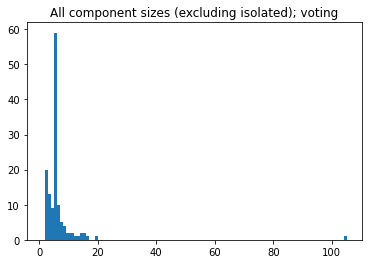

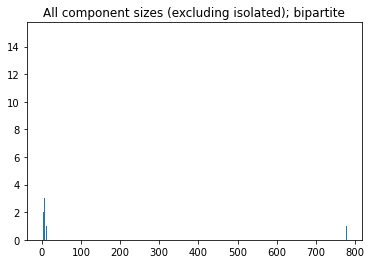

In [74]:
thresh = 0.0

G = get_subgraph_with_strong_weights(DG, thresh)
big_G, all_sz = calc_connected_components(G)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes (excluding isolated); voting')

plt.figure()
G = get_subgraph_with_strong_weights(DG2, thresh)
big_G, all_sz = calc_connected_components(G)
plt.hist([z for z in all_sz if z > 1], bins=list(range(1,max(all_sz)+2)));
plt.title('All component sizes (excluding isolated); bipartite')

# [vals, counts] = np.unique(all_sz, return_counts=True)
# print("Sizes and number of components:")
# for v, c in zip(vals, counts):
#       print([v, c])

In [88]:
[m for m in bp_matches[(0,1)] if m[0]==122]
# bp_matches[(0,2)]

[[122, 70]]

In [99]:
#DG2.edges()

In [100]:
#big_G.edges()

## Build a global set of neurons

In [79]:
# How similar are bp matches and voting matches?
def intersection(list1, list2):
    return [val for val in list1 if val in list2]

In [101]:
k = (0,1)

#print(intersection(pairwise_matches[k], bp_matches[k]))
#intersection(pairwise_matches[k], [[5,26],[9,21]])


In [137]:
global_neuron_dict

{0: [81, 72, 138, 38, 198],
 1: [149, 200, 244, 110, 157],
 2: [69, 31, 152, 94, 15],
 3: [165, 205, 193, 252, 119],
 4: [55, 105, 10, 21, 167],
 5: [74, 101, 159, 121, 51],
 6: [51, 44, 177, 173, 232],
 7: [25, 6, 66, 119, 160],
 8: [188, 174, 284, 141, 218],
 9: [98, 207, 97, 46, 154],
 10: [67, 212, 111, 98, 151],
 11: [85, 94, 119, 152, 50],
 12: [173, 134, 78, 48, 78],
 13: [234, 94, 121, 143, 186],
 14: [96, 128, 83, 174, 44],
 15: [103, 143, 96, 76, 192],
 16: [232, 80, 105, 99, 185],
 17: [112, 204, 167, 73, 94],
 18: [142, 22, 166, 190, 143],
 19: [204, 191, 250, 113, 158],
 20: [132, 119, 101, 178, 226],
 21: [75, 71, 37, 3, 120],
 22: [144, 93, 176, 222, 86],
 23: [96, 125, 213, 180, 123],
 24: [97, 98, 129, 217, 179],
 25: [176, 72, 149, 87, 107],
 26: [80, 153, 117, 85, 49],
 27: [61, 86, 113, 118, 164],
 28: [60, 175, 93, 79, 122],
 29: [164, 117, 102, 191, 85],
 30: [63, 88, 110, 161, 127],
 31: [147, 237, 197, 104, 153],
 32: [170, 30, 107, 68, 61],
 33: [178, 36, 77, 1

# Clustering tests:


In [ ]:
# Cluster based on graph embedding:
# https://stackoverflow.com/questions/62902871/how-can-i-cluster-a-graph-g-created-in-networkx

from node2vec import Node2Vec
# Generate walks
node2vec = Node2Vec(big_DG, dimensions=2, walk_length=5, num_walks=10,workers=4)
# Learn embeddings 
model = node2vec.fit(window=10, min_count=1)
#model.wv.most_similar('1')
model.wv.save_word2vec_format("embedding.emb") #save the embedding in file embedding.emb

In [ ]:
from sklearn.cluster import KMeans

X = np.loadtxt("embedding.emb", skiprows=1) # load the embedding of the nodes of the graph
#print(X)
# sort the embedding based on node index in the first column in X
X=X[X[:,0].argsort()]; 
Z=X[0:X.shape[0],1:X.shape[1]]; # remove the node index from X and save in Z

kmeans = KMeans(n_clusters=300, random_state=0).fit(Z) # apply kmeans on Z
labels=kmeans.labels_  # get the cluster labels of the nodes.
print(labels)

In [ ]:
nx.draw(big_DG, node_color=labels)

In [ ]:
# Other clustering method:
# https://networkx.org/documentation/stable/auto_examples/algorithms/plot_blockmodel.html#sphx-glr-auto-examples-algorithms-plot-blockmodel-py
from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
from scipy.cluster import hierarchy
from scipy.spatial import distance


def create_hc(G):
    """Creates hierarchical cluster of graph G from distance matrix"""
    path_length = nx.all_pairs_shortest_path_length(G)
    distances = np.zeros((len(G), len(G)))
    for u, p in path_length:
        for v, d in p.items():
            distances[u][v] = d
    # Create hierarchical cluster
    Y = distance.squareform(distances)
    Z = hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership = list(hierarchy.fcluster(Z, t=1.15))
    # Create collection of lists for blockmodel
    partition = defaultdict(list)
    for n, p in zip(list(range(len(G))), membership):
        partition[p].append(n)
    return list(partition.values())


G = big_DG.to_undirected()

# Extract largest connected component into graph H
H = G.subgraph(next(nx.connected_components(G)))
# Makes life easier to have consecutively labeled integer nodes
H = nx.convert_node_labels_to_integers(H)
# Create parititions with hierarchical clustering
partitions = create_hc(H)
# Build blockmodel graph
BM = nx.quotient_graph(H, partitions, relabel=True)

# Draw original graph
pos = nx.spring_layout(H, iterations=100)
plt.subplot(211)
nx.draw(H, pos, with_labels=False, node_size=10)

# Draw block model with weighted edges and nodes sized by number of internal nodes
node_size = [BM.nodes[x]["nnodes"] * 10 for x in BM.nodes()]
edge_width = [(2 * d["weight"]) for (u, v, d) in BM.edges(data=True)]
# Set positions to mean of positions of internal nodes from original graph
posBM = {}
for n in BM:
    xy = np.array([pos[u] for u in BM.nodes[n]["graph"]])
    posBM[n] = xy.mean(axis=0)
plt.subplot(212)
nx.draw(BM, posBM, node_size=node_size, width=edge_width, with_labels=False)
plt.axis("off")
plt.show()

# Testing feature matching

In [ ]:
import cv2
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import *
im = get_single_volume(btf_fname_red, 0, num_slices=33)[0,...]

In [ ]:
im.shape
kp, d = detect_features(im, 1000)

In [ ]:
kp[0].pt



In [ ]:
dat = get_single_volume(btf_fname_red, 0, num_slices=33)
dat.shape[1:]

In [ ]:
cv2.KeyPoint.convert(kp2[0,...])
#kp3 = cv2.KeyPoint_convert(kp2)

In [ ]:
a = [1, 3, 5, 7]
b = [3, 5, 6]

In [ ]:
[a.index(val) if val in a for val in b]


In [ ]:
a[0,0]

# Test feature detectors

In [ ]:
dat = get_single_volume(btf_fname_red, 0, 33, 0.15)

import scipy.ndimage as ndi
dat_max = ndi.maximum_filter(dat, size=(5,1,1))

In [ ]:
%matplotlib inline
plt.figure(figsize=(25,45))
plt.imshow(dat[21,...])
plt.figure(figsize=(25,45))
plt.imshow(dat_max[21,...])

In [ ]:
print(dat[10:15,-1,-1])
print(dat[1,...])

print(dat_max[1,...])

In [ ]:
dat_max.shape